In [1]:
# Importing Libraries

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [3]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [4]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [5]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [6]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [7]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [8]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [86]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [87]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [9]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [10]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()
print("X train shape :",X_train.shape)
print("X test shape :",X_test.shape)
print("Y train shape :",Y_train.shape)
print("Y train shape :",Y_test.shape)

C:\Users\patha\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


X train shape : (7352, 128, 9)
X test shape : (2947, 128, 9)
Y train shape : (7352, 6)
Y train shape : (2947, 6)


C:\Users\patha\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [11]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


- Defining the Architecture of LSTM

In [91]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [23]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 92s 13ms/step - loss: 1.3018 - acc: 0.4395 - val_loss: 1.1254 - val_acc: 0.4662
Epoch 2/30
7352/7352 [==============================] - 94s 13ms/step - loss: 0.9666 - acc: 0.5880 - val_loss: 0.9491 - val_acc: 0.5714
Epoch 3/30
7352/7352 [==============================] - 97s 13ms/step - loss: 0.7812 - acc: 0.6408 - val_loss: 0.8286 - val_acc: 0.5850
Epoch 4/30
7352/7352 [==============================] - 95s 13ms/step - loss: 0.6941 - acc: 0.6574 - val_loss: 0.7297 - val_acc: 0.6128
Epoch 5/30
7352/7352 [==============================] - 92s 13ms/step - loss: 0.6336 - acc: 0.6912 - val_loss: 0.7359 - val_acc: 0.6787
Epoch 6/30
7352/7352 [==============================] - 94s 13ms/step - loss: 0.5859 - acc: 0.7134 - val_loss: 0.7015 - val_acc: 0.6939
Epoch 7/30
7352/7352 [==============================] - 95s 13ms/step - loss: 0.5692 - acc: 0.7477 - val_loss: 0.5995 - val_acc: 0.7387


In [24]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 512        0        25        0                   0   
SITTING                  3      410        75        0                   0   
STANDING                 0       87       445        0                   0   
WALKING                  0        0         0      481                   2   
WALKING_DOWNSTAIRS       0        0         0        0                 382   
WALKING_UPSTAIRS         0        0         0        2                  18   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            3  
STANDING                           0  
WALKING                           13  
WALKING_DOWNSTAIRS                38  
WALKING_UPSTAIRS                 451  


In [27]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 4s 2ms/step


In [28]:
score

[0.3087582236972612, 0.9097387173396675]

- With a simple 2 layer architecture we got 90.09% accuracy and a loss of 0.30
- We can further imporve the performace with Hyperparameter tuning

### Assignment

#### 2 LSTM Layers

In [282]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Activation,BatchNormalization,Conv2D,Flatten,TimeDistributed,Conv1D
from keras.regularizers import *
from keras.callbacks import LearningRateScheduler,TerminateOnNaN,EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.initializers import VarianceScaling
from keras.optimizers import *

In [283]:
import math
def lr_decay(epoch):
    return float(0.0001 * math.pow(0.6, math.floor((1+epoch)/10)))
lr = LearningRateScheduler(lr_decay)
tm = TerminateOnNaN()
es = EarlyStopping(monitor = 'accuracy')
init = VarianceScaling(scale = 1.0,mode = 'fan_avg',distribution = 'normal')
adam = Adam(lr=0.001)
rmsprop = RMSprop(lr = 0.001)

In [62]:

model = Sequential()
model.add(LSTM(32,activation = 'relu',return_sequences=True, input_shape=(timesteps, input_dim),recurrent_initializer="glorot_uniform",recurrent_regularizer=l2(0.003) ))
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(LSTM(32,recurrent_initializer="glorot_uniform",recurrent_regularizer=l2(0.003)))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(6, activation='sigmoid'))
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 128, 32)           5376      
_________________________________________________________________
batch_normalization_22 (Batc (None, 128, 32)           128       
_________________________________________________________________
dropout_22 (Dropout)         (None, 128, 32)           0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 32)                8320      
_________________________________________________________________
batch_normalization_23 (Batc (None, 32)                128       
_________________________________________________________________
dropout_23 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 6)               

In [63]:
%%time
model.compile(loss='categorical_crossentropy',
          optimizer=adam,
          metrics=['accuracy'])

Wall time: 31.9 ms


In [64]:
%%time
# Training the model
result = model.fit(X_train,
          Y_train,
          batch_size=32,
          validation_data=(X_test, Y_test),callbacks=[lr,tm],
          epochs=30,verbose = 1)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 67s 9ms/step - loss: 1.3829 - accuracy: 0.5645 - val_loss: 1.1387 - val_accuracy: 0.5826
Epoch 2/30
7352/7352 [==============================] - 70s 10ms/step - loss: 0.9055 - accuracy: 0.6557 - val_loss: 0.8158 - val_accuracy: 0.5864
Epoch 3/30
7352/7352 [==============================] - 69s 9ms/step - loss: 0.7707 - accuracy: 0.6740 - val_loss: 0.8092 - val_accuracy: 0.6583
Epoch 4/30
7352/7352 [==============================] - 68s 9ms/step - loss: 0.6547 - accuracy: 0.7334 - val_loss: 1.1115 - val_accuracy: 0.6464
Epoch 5/30
7352/7352 [==============================] - 67s 9ms/step - loss: 0.4773 - accuracy: 0.8672 - val_loss: 1.3450 - val_accuracy: 0.6844
Epoch 6/30
7352/7352 [==============================] - 63s 9ms/step - loss: 0.3395 - accuracy: 0.9142 - val_loss: 2.3442 - val_accuracy: 0.5894
Epoch 7/30
7352/7352 [==============================] - 63s 9ms/step - loss: 0.29

In [65]:
model.evaluate(X_test,Y_test)

2947/2947 [==============================] - 11s 4ms/step


[0.3971564822520872, 0.9178826212882996]

In [66]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 537        0         0        0                   0   
SITTING                  0      408        78        0                   0   
STANDING                 0       91       441        0                   0   
WALKING                  0        0         0      462                  33   
WALKING_DOWNSTAIRS       0        0         0        1                 418   
WALKING_UPSTAIRS         0        0         1        8                  23   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            5  
STANDING                           0  
WALKING                            1  
WALKING_DOWNSTAIRS                 1  
WALKING_UPSTAIRS                 439  


### 3 LSTM Layers

In [67]:
model = Sequential()
model.add(LSTM(16,activation = 'relu',return_sequences=True, input_shape=(timesteps, input_dim),recurrent_initializer="glorot_uniform",recurrent_regularizer=l2(0.003) ))
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(LSTM(16,return_sequences=True,recurrent_initializer="glorot_uniform",recurrent_regularizer=l2(0.003)))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(LSTM(16,recurrent_initializer="glorot_uniform",recurrent_regularizer=l2(0.003)))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(6, activation='sigmoid'))
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 128, 16)           1664      
_________________________________________________________________
batch_normalization_24 (Batc (None, 128, 16)           64        
_________________________________________________________________
dropout_24 (Dropout)         (None, 128, 16)           0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 128, 16)           2112      
_________________________________________________________________
batch_normalization_25 (Batc (None, 128, 16)           64        
_________________________________________________________________
dropout_25 (Dropout)         (None, 128, 16)           0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 16)              

In [68]:
%%time
model.compile(loss='categorical_crossentropy',
          optimizer=adam,
          metrics=['accuracy'])

Wall time: 46.9 ms


In [69]:
%%time
# Training the model
result = model.fit(X_train,
          Y_train,
          batch_size=32,
          validation_data=(X_test, Y_test),callbacks=[lr,tm],
          epochs=30,verbose = 1)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 96s 13ms/step - loss: 1.0784 - accuracy: 0.6155 - val_loss: 2.4525 - val_accuracy: 0.2104
Epoch 2/30
7352/7352 [==============================] - 93s 13ms/step - loss: 0.8143 - accuracy: 0.6495 - val_loss: 1.8998 - val_accuracy: 0.3624
Epoch 3/30
7352/7352 [==============================] - 93s 13ms/step - loss: 0.7552 - accuracy: 0.6600 - val_loss: 0.7603 - val_accuracy: 0.6135
Epoch 4/30
7352/7352 [==============================] - 94s 13ms/step - loss: 0.7052 - accuracy: 0.6668 - val_loss: 0.8918 - val_accuracy: 0.5836
Epoch 5/30
7352/7352 [==============================] - 93s 13ms/step - loss: 0.6817 - accuracy: 0.6634 - val_loss: 0.8573 - val_accuracy: 0.5813
Epoch 6/30
7352/7352 [==============================] - 93s 13ms/step - loss: 0.6373 - accuracy: 0.6685 - val_loss: 2.4977 - val_accuracy: 0.3264
Epoch 7/30
7352/7352 [==============================] - 94s 13ms/step - loss

In [70]:
model.evaluate(X_test,Y_test)

2947/2947 [==============================] - 15s 5ms/step


[0.48638685676640564, 0.8951476216316223]

In [71]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 510        0         0        0                   0   
SITTING                  5      415        64        1                   0   
STANDING                 0      104       427        0                   0   
WALKING                  0        0         0      493                   1   
WALKING_DOWNSTAIRS       0        0         0       54                 366   
WALKING_UPSTAIRS         0        2         0       31                  11   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                            27  
SITTING                            6  
STANDING                           1  
WALKING                            2  
WALKING_DOWNSTAIRS                 0  
WALKING_UPSTAIRS                 427  


In [365]:
model = Sequential()
model.add(LSTM(100,activation = 'relu',return_sequences=True, input_shape=(timesteps, input_dim),recurrent_initializer="glorot_uniform",recurrent_regularizer=l2(0.003) ))
model.add(BatchNormalization())
model.add(Dropout(0.8))
model.add(LSTM(100,recurrent_initializer="glorot_uniform",recurrent_regularizer=l2(0.0003)))
model.add(BatchNormalization())
model.add(Dropout(0.8))
# model.add(LSTM(28,return_sequences=True,recurrent_initializer="glorot_uniform",recurrent_regularizer=l2(0.0003)))
# model.add(BatchNormalization())
# model.add(Dropout(0.8))
# # model.add(LSTM(64,return_sequences=True,recurrent_initializer="glorot_uniform",recurrent_regularizer=l2(0.003)))
# # model.add(BatchNormalization())
# # model.add(Dropout(0.6))
# model.add(LSTM(16,recurrent_initializer="glorot_uniform",recurrent_regularizer=l2(0.0003)))
# model.add(BatchNormalization())
# model.add(Dropout(0.8))
model.add(Dense(n_classes, activation='softmax'))
model.summary()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 128, 100)          44000     
_________________________________________________________________
batch_normalization_69 (Batc (None, 128, 100)          400       
_________________________________________________________________
dropout_130 (Dropout)        (None, 128, 100)          0         
_________________________________________________________________
lstm_37 (LSTM)               (None, 100)               80400     
_________________________________________________________________
batch_normalization_70 (Batc (None, 100)               400       
_________________________________________________________________
dropout_131 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_70 (Dense)             (None, 6)               

In [366]:
%%time
model.compile(loss='categorical_crossentropy',
          optimizer=adam,
          metrics=['accuracy'])

Wall time: 47.9 ms


In [367]:
%%time
# Training the model
result = model.fit(X_train,
          Y_train,
          batch_size=32,
          validation_data=(X_test, Y_test),callbacks=[lr,tm],
          epochs=50,verbose = 1)

Train on 7352 samples, validate on 2947 samples
Epoch 1/50
7352/7352 [==============================] - 71s 10ms/step - loss: 1.9772 - accuracy: 0.5590 - val_loss: 1.1925 - val_accuracy: 0.6155
Epoch 2/50
7352/7352 [==============================] - 63s 9ms/step - loss: 1.3167 - accuracy: 0.6606 - val_loss: 1.1295 - val_accuracy: 0.6603
Epoch 3/50
7352/7352 [==============================] - 64s 9ms/step - loss: 1.1459 - accuracy: 0.6821 - val_loss: 1.0407 - val_accuracy: 0.7380
Epoch 4/50
7352/7352 [==============================] - 66s 9ms/step - loss: 1.0348 - accuracy: 0.7121 - val_loss: 0.9470 - val_accuracy: 0.7513
Epoch 5/50
7352/7352 [==============================] - 69s 9ms/step - loss: 0.9272 - accuracy: 0.7422 - val_loss: 0.9104 - val_accuracy: 0.7638
Epoch 6/50
7352/7352 [==============================] - 65s 9ms/step - loss: 0.8319 - accuracy: 0.7705 - val_loss: 0.9305 - val_accuracy: 0.7760
Epoch 7/50
7352/7352 [==============================] - 63s 9ms/step - loss: 0.73

KeyboardInterrupt: 

### Using CNN

In [12]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Activation,BatchNormalization,Conv2D,Flatten,TimeDistributed,Conv1D,MaxPool1D
from keras.regularizers import *
from keras.callbacks import LearningRateScheduler,TerminateOnNaN
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.initializers import VarianceScaling
from keras.optimizers import *

In [13]:
import math
def lr_decay(epoch):
    return float(0.001 * math.pow(0.6, math.floor((1+epoch)/10)))
lr = LearningRateScheduler(lr_decay)
tm = TerminateOnNaN()
init = VarianceScaling(scale = 1.0,mode = 'fan_avg',distribution = 'normal')
adam = Adam(lr=0.001)
rmsprop = RMSprop(lr = 0.001)

#### Model 1 CNN

In [29]:
model1 = Sequential()
model1.add(Conv1D(128,kernel_size=3,kernel_initializer='he_normal',input_shape=(timesteps, input_dim),kernel_regularizer = l2(0.003),activation ='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.7))
model1.add(MaxPool1D(2))
# model1.add(Conv1D(64,kernel_size=3,kernel_initializer='he_normal',kernel_regularizer = l2(0.003),activation ='relu'))
# model1.add(BatchNormalization())
# model1.add(Dropout(0.5))
model1.add(Conv1D(32,kernel_size=3,kernel_initializer='he_normal',kernel_regularizer = l2(0.003),activation ='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.5))
model1.add(MaxPool1D(2))
model1.add(Flatten())
model1.add(Dense(64,activation = 'relu'))
model1.add(Dropout(0.5))
model1.add(Dense(n_classes,activation = 'softmax'))
model1.summary()

W1020 15:47:24.126830  3136 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W1020 15:47:24.139796  3136 deprecation_wrapper.py:119] From C:\Users\patha\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 126, 128)          3584      
_________________________________________________________________
batch_normalization_10 (Batc (None, 126, 128)          512       
_________________________________________________________________
dropout_13 (Dropout)         (None, 126, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 63, 128)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 61, 32)            12320     
_________________________________________________________________
batch_normalization_11 (Batc (None, 61, 32)            128       
_________________________________________________________________
dropout_14 (Dropout)         (None, 61, 32)           

In [32]:
%%time
model1.compile(loss='categorical_crossentropy',
          optimizer=adam,
          metrics=['accuracy'])

Wall time: 62 ms


In [33]:
%%time
# Training the model
result = model1.fit(X_train,
          Y_train,
          batch_size=32,
          validation_data=(X_test, Y_test),callbacks=[lr,tm],
          epochs=30,verbose = 1)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 4s 515us/step - loss: 1.9771 - accuracy: 0.5979 - val_loss: 4.9397 - val_accuracy: 0.3207
Epoch 2/30
7352/7352 [==============================] - 3s 380us/step - loss: 1.4026 - accuracy: 0.7314 - val_loss: 4.1904 - val_accuracy: 0.4869
Epoch 3/30
7352/7352 [==============================] - 3s 366us/step - loss: 1.1415 - accuracy: 0.8052 - val_loss: 2.9938 - val_accuracy: 0.5724
Epoch 4/30
7352/7352 [==============================] - 3s 368us/step - loss: 0.9091 - accuracy: 0.8596 - val_loss: 2.8087 - val_accuracy: 0.5935
Epoch 5/30
7352/7352 [==============================] - 3s 370us/step - loss: 0.7309 - accuracy: 0.8988 - val_loss: 2.2223 - val_accuracy: 0.6464
Epoch 6/30
7352/7352 [==============================] - 3s 369us/step - loss: 0.6076 - accuracy: 0.9199 - val_loss: 2.1633 - val_accuracy: 0.6793
Epoch 7/30
7352/7352 [==============================] - 3s 373us/step - loss

In [38]:
model1.evaluate(X_test,Y_test)

2947/2947 [==============================] - 0s 149us/step


[0.4131184876278614, 0.9015948176383972]

In [40]:
# Confusion Matrix
print(confusion_matrix(Y_test, model1.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 537        0         0        0                   0   
SITTING                  0      326       164        0                   0   
STANDING                 0       44       488        0                   0   
WALKING                  0       11        14      449                   0   
WALKING_DOWNSTAIRS       0        0         8        1                 401   
WALKING_UPSTAIRS         0        7         0        0                   8   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            1  
STANDING                           0  
WALKING                           22  
WALKING_DOWNSTAIRS                10  
WALKING_UPSTAIRS                 456  


#### Model2 CNN

In [54]:
model2 = Sequential()
model2.add(Conv1D(128,kernel_size=7,kernel_initializer='he_normal',input_shape=(timesteps, input_dim),kernel_regularizer = l2(0.003),activation ='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.7))
model2.add(MaxPool1D(2))
# model2.add(Conv1D(64,kernel_size=3,kernel_initializer='he_normal',kernel_regularizer = l2(0.003),activation ='relu'))
# model2.add(BatchNormalization())
# model2.add(Dropout(0.5))
model2.add(Conv1D(64,kernel_size=7,kernel_initializer='he_normal',kernel_regularizer = l2(0.003),activation ='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.7))
model2.add(MaxPool1D(2))
model2.add(Flatten())
model2.add(Dense(32,activation = 'relu'))
model2.add(Dropout(0.5))
model2.add(Dense(n_classes,activation = 'softmax'))
model2.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_22 (Conv1D)           (None, 122, 128)          8192      
_________________________________________________________________
batch_normalization_22 (Batc (None, 122, 128)          512       
_________________________________________________________________
dropout_31 (Dropout)         (None, 122, 128)          0         
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 61, 128)           0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 55, 64)            57408     
_________________________________________________________________
batch_normalization_23 (Batc (None, 55, 64)            256       
_________________________________________________________________
dropout_32 (Dropout)         (None, 55, 64)          

In [55]:
%%time
model2.compile(loss='categorical_crossentropy',
          optimizer=adam,
          metrics=['accuracy'])

Wall time: 40.9 ms


In [56]:
%%time
# Training the model
result = model2.fit(X_train,
          Y_train,
          batch_size=64,
          validation_data=(X_test, Y_test),callbacks=[lr,tm],
          epochs=30,verbose = 1)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 3s 435us/step - loss: 2.0337 - accuracy: 0.5975 - val_loss: 8.0444 - val_accuracy: 0.3563
Epoch 2/30
7352/7352 [==============================] - 2s 257us/step - loss: 1.4303 - accuracy: 0.6749 - val_loss: 11.8737 - val_accuracy: 0.3539
Epoch 3/30
7352/7352 [==============================] - 2s 255us/step - loss: 1.1435 - accuracy: 0.7125 - val_loss: 11.7078 - val_accuracy: 0.3841
Epoch 4/30
7352/7352 [==============================] - 2s 256us/step - loss: 0.8885 - accuracy: 0.7900 - val_loss: 7.3924 - val_accuracy: 0.4835
Epoch 5/30
7352/7352 [==============================] - 2s 267us/step - loss: 0.6426 - accuracy: 0.8788 - val_loss: 5.6671 - val_accuracy: 0.5317
Epoch 6/30
7352/7352 [==============================] - 2s 260us/step - loss: 0.5403 - accuracy: 0.8962 - val_loss: 3.0467 - val_accuracy: 0.6603
Epoch 7/30
7352/7352 [==============================] - 2s 256us/step - lo

In [57]:
model2.evaluate(X_test,Y_test)

2947/2947 [==============================] - 1s 171us/step


[0.6932297824882919, 0.8561248779296875]

In [59]:
# Confusion Matrix
print(confusion_matrix(Y_test, model2.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 537        0         0        0                   0   
SITTING                  5      321       164        0                   0   
STANDING                 0       25       507        0                   0   
WALKING                  0        0        80      416                   0   
WALKING_DOWNSTAIRS       0       10         7       13                 385   
WALKING_UPSTAIRS         0       65        27        4                  18   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            1  
STANDING                           0  
WALKING                            0  
WALKING_DOWNSTAIRS                 5  
WALKING_UPSTAIRS                 357  


#### Using Divide and Conquer Based Approach

In [15]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))


In [16]:
def load_y_bi(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]
    y[y<=3] = 0
    y[y>3] = 1
    return pd.get_dummies(y).as_matrix()

def load_data_bi():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train,y_test = load_y_bi('train'),load_y_bi("test")
    return X_train, X_test, y_train, y_test

In [17]:
X_train_bi,X_test_bi,Y_train_bi,Y_test_bi  = load_data_bi()

C:\Users\patha\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [18]:
model_bi= Sequential()
model_bi.add(Conv1D(32,kernel_size=3,kernel_initializer='he_normal',input_shape=(timesteps, input_dim),kernel_regularizer = l2(0.003),activation ='relu'))
#model_bi.add(BatchNormalization())
#model_bi.add(MaxPool1D(2))
model_bi.add(Conv1D(32,kernel_size=3,kernel_initializer='he_normal',kernel_regularizer = l2(0.003),activation ='relu'))
#model_bi.add(BatchNormalization())
model_bi.add(Dropout(0.6))
model_bi.add(MaxPool1D(2))
model_bi.add(Flatten())
model_bi.add(Dense(64,activation = 'relu'))
# model_bi.add(Dropout(0.5))
model_bi.add(Dense(2,activation = 'softmax'))
model_bi.summary()

W1023 16:24:53.602773  7024 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W1023 16:24:53.637979  7024 deprecation_wrapper.py:119] From C:\Users\patha\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 126, 32)           896       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 124, 32)           3104      
_________________________________________________________________
dropout_1 (Dropout)          (None, 124, 32)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 62, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1984)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                127040    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                

In [19]:
%%time
model_bi.compile(loss='categorical_crossentropy',
          optimizer=adam,
          metrics=['accuracy'])

Wall time: 165 ms


In [20]:
%%time
# Training the model
result = model_bi.fit(X_train_bi,
          Y_train_bi,
          batch_size=64,
          validation_data=(X_test_bi, Y_test_bi),callbacks=[lr,tm],
          epochs=30,verbose = 1)

W1023 16:25:01.943298  7024 deprecation_wrapper.py:119] From C:\Users\patha\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 8s 1ms/step - loss: 0.3814 - accuracy: 0.9814 - val_loss: 0.3111 - val_accuracy: 0.9891
Epoch 2/30
7352/7352 [==============================] - 2s 291us/step - loss: 0.2390 - accuracy: 0.9992 - val_loss: 0.2380 - val_accuracy: 0.9810
Epoch 3/30
7352/7352 [==============================] - 2s 278us/step - loss: 0.1721 - accuracy: 0.9986 - val_loss: 0.2054 - val_accuracy: 0.9779
Epoch 4/30
7352/7352 [==============================] - 2s 280us/step - loss: 0.1266 - accuracy: 0.9995 - val_loss: 0.1782 - val_accuracy: 0.9756
Epoch 5/30
7352/7352 [==============================] - 2s 285us/step - loss: 0.0982 - accuracy: 0.9990 - val_loss: 0.1229 - val_accuracy: 0.9844
Epoch 6/30
7352/7352 [==============================] - 2s 294us/step - loss: 0.0754 - accuracy: 0.9996 - val_loss: 0.0871 - val_accuracy: 0.9891
Epoch 7/30
7352/7352 [==============================] - 2s 274us/step - loss: 

In [21]:
model_bi.evaluate(X_test_bi,Y_test_bi)

2947/2947 [==============================] - 1s 216us/step


[0.01310468845076993, 0.9986426830291748]

In [22]:
# Confusion Matrix
print(confusion_matrix(Y_test, model_bi.predict(X_test_bi)))

Pred                WALKING  WALKING_UPSTAIRS
True                                         
LAYING                    0               537
SITTING                   2               489
STANDING                  2               530
WALKING                 496                 0
WALKING_DOWNSTAIRS      420                 0
WALKING_UPSTAIRS        471                 0


In [101]:
model_bi.save("model_bi_class.h5")

In [258]:
def load_y_new(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]
    label_y = y>3
    new_y = y[label_y]
    return pd.get_dummies(new_y).as_matrix(),label_y

def load_data_new():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train_new, y_label_train = load_y_new('train')
    y_val_new,y_label_test = load_y_new('test')
    X_train_new = X_train[y_label_train]
    X_val_new = X_test[y_label_test]
    return X_train_new, X_val_new, y_train_new, y_val_new

In [259]:
X_train_st,X_test_st,Y_train_st,Y_test_st  = load_data_new()

In [273]:
model_st= Sequential()
model_st.add(Conv1D(30,kernel_size=3,kernel_initializer='glorot_normal',input_shape=(timesteps, input_dim),kernel_regularizer = l2(0.0003),activation ='relu'))
model_st.add(BatchNormalization())
model_st.add(Dropout(0.7))
# model_st.add(MaxPool1D(2))
model_st.add(Conv1D(50,kernel_size=3,kernel_initializer='glorot_normal',kernel_regularizer = l2(0.0003),activation ='relu'))
model_st.add(BatchNormalization())
model_st.add(Dropout(0.4))
model_st.add(Conv1D(100,kernel_size=3,kernel_initializer='glorot_normal',kernel_regularizer = l2(0.0003),activation ='relu'))
model_st.add(BatchNormalization())
model_st.add(Dropout(0.4))
#model_st.add(MaxPool1D(2))
model_st.add(Flatten())
model_st.add(Dense(100,activation = 'relu'))
model_st.add(Dropout(0.6))
model_st.add(Dense(3,activation = 'softmax'))
model_st.summary()
# model_st = Sequential()
# model_st.add(Conv1D(100,kernel_size=3,kernel_initializer='he_normal',input_shape=(timesteps, input_dim),kernel_regularizer = l2(0.0003),activation ='relu'))
# model_st.add(BatchNormalization())
# model_st.add(Dropout(0.7))
# # model_st.add(MaxPool1D(2))
# model_st.add(Conv1D(100,kernel_size=3,kernel_initializer='he_normal',kernel_regularizer = l2(0.0003),activation ='relu'))
# model_st.add(BatchNormalization())
# model_st.add(Dropout(0.7))
# model_st.add(Conv1D(500,kernel_size=3,kernel_initializer='he_normal',kernel_regularizer = l2(0.0003),activation ='relu'))
# model_st.add(BatchNormalization())
# model_st.add(Dropout(0.7))
# #model_st.add(MaxPool1D(2))
# model_st.add(Flatten())
# model_st.add(Dense(32,activation = 'relu'))
# model_st.add(Dropout(0.2))
# model_st.add(Dense(3,activation = 'softmax'))
# model_st.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_57 (Conv1D)           (None, 126, 30)           840       
_________________________________________________________________
batch_normalization_25 (Batc (None, 126, 30)           120       
_________________________________________________________________
dropout_63 (Dropout)         (None, 126, 30)           0         
_________________________________________________________________
conv1d_58 (Conv1D)           (None, 124, 50)           4550      
_________________________________________________________________
batch_normalization_26 (Batc (None, 124, 50)           200       
_________________________________________________________________
dropout_64 (Dropout)         (None, 124, 50)           0         
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 122, 100)        

In [274]:
%%time
model_st.compile(loss='categorical_crossentropy',
          optimizer=adam,
          metrics=['accuracy'])

Wall time: 57.8 ms


In [275]:
%%time
# Training the model
result = model_st.fit(X_train_st,
          Y_train_st,
          batch_size=64,
          validation_data=(X_test_st, Y_test_st),callbacks=[lr,tm],
          epochs=30,verbose = 1)

Train on 4067 samples, validate on 1560 samples
Epoch 1/30
4067/4067 [==============================] - 3s 690us/step - loss: 0.8004 - accuracy: 0.8328 - val_loss: 1.5153 - val_accuracy: 0.5128
Epoch 2/30
4067/4067 [==============================] - 1s 346us/step - loss: 0.3486 - accuracy: 0.8925 - val_loss: 0.6679 - val_accuracy: 0.5929
Epoch 3/30
4067/4067 [==============================] - 1s 342us/step - loss: 0.2994 - accuracy: 0.8945 - val_loss: 0.5829 - val_accuracy: 0.7795
Epoch 4/30
4067/4067 [==============================] - 1s 345us/step - loss: 0.3227 - accuracy: 0.9002 - val_loss: 0.4661 - val_accuracy: 0.8276
Epoch 5/30
4067/4067 [==============================] - 1s 336us/step - loss: 0.3862 - accuracy: 0.8849 - val_loss: 0.3554 - val_accuracy: 0.8635
Epoch 6/30
4067/4067 [==============================] - 1s 334us/step - loss: 0.2901 - accuracy: 0.8930 - val_loss: 0.3619 - val_accuracy: 0.8718
Epoch 7/30
4067/4067 [==============================] - 1s 341us/step - loss

In [277]:
# Confusion Matrix
#print(confusion_matrix(np.argmax(Y_test_st,axis=1), np.argmax(model_st.predict(X_test_st),axis=1)))
model_st.evaluate(X_test_st,Y_test_st)

1560/1560 [==============================] - 0s 199us/step


[0.3938026012136386, 0.8935897350311279]

In [ ]:
print(confusion_matrix(np.argmax(Y_test_st,axis=1), np.argmax(model_st.predict(X_test_st),axis=1)))

In [276]:
model_st.save("model_st_class.h5")

In [23]:
def load_y_new(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]
    label_y = y<=3
    new_y = y[label_y]
    return pd.get_dummies(new_y).as_matrix(),label_y

def load_data_new():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train_new, y_label_train = load_y_new('train')
    y_val_new,y_label_test = load_y_new('test')
    X_train_new = X_train[y_label_train]
    X_val_new = X_test[y_label_test]
    return X_train_new, X_val_new, y_train_new, y_val_new

In [24]:
X_train_dy,X_test_dy,Y_train_dy,Y_test_dy  = load_data_new()

C:\Users\patha\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [207]:
model_dy= Sequential()
model_dy.add(Conv1D(64,kernel_size=5,kernel_initializer='glorot_normal',input_shape=(timesteps, input_dim),kernel_regularizer = l2(0.0003),activation ='relu'))
#model_dy.add(BatchNormalization())
#model_dy.add(MaxPool1D(2))
model_dy.add(Conv1D(32,kernel_size=5,kernel_initializer='glorot_normal',kernel_regularizer = l2(0.0003),activation ='relu'))
#model_dy.add(BatchNormalization())
model_dy.add(Dropout(0.7))
# model_dy.add(Conv1D(32,kernel_size=7,kernel_initializer='he_normal',kernel_regularizer = l2(0.003),activation ='relu'))
# #model_dy.add(BatchNormalization())
# model_dy.add(Dropout(0.6))
model_dy.add(MaxPool1D(2))
model_dy.add(Flatten())
model_dy.add(Dense(16,activation = 'relu'))
model_dy.add(Dropout(0.2))
model_dy.add(Dense(3,activation = 'softmax'))
model_dy.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_37 (Conv1D)           (None, 124, 64)           2944      
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 120, 32)           10272     
_________________________________________________________________
dropout_39 (Dropout)         (None, 120, 32)           0         
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 60, 32)            0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 1920)              0         
_________________________________________________________________
dense_34 (Dense)             (None, 16)                30736     
_________________________________________________________________
dropout_40 (Dropout)         (None, 16)              

In [208]:
%%time
model_dy.compile(loss='categorical_crossentropy',
          optimizer=adam,
          metrics=['accuracy'])

Wall time: 122 ms


In [209]:
%%time
# Training the model
result = model_dy.fit(X_train_dy,
          Y_train_dy,
          batch_size=64,
          validation_data=(X_test_dy, Y_test_dy),callbacks=[lr,tm],
          epochs=30,verbose = 1)

Train on 3285 samples, validate on 1387 samples
Epoch 1/30
3285/3285 [==============================] - 1s 439us/step - loss: 0.6504 - accuracy: 0.7233 - val_loss: 0.5196 - val_accuracy: 0.8558
Epoch 2/30
3285/3285 [==============================] - 1s 216us/step - loss: 0.1447 - accuracy: 0.9589 - val_loss: 0.2770 - val_accuracy: 0.9387
Epoch 3/30
3285/3285 [==============================] - 1s 201us/step - loss: 0.0706 - accuracy: 0.9854 - val_loss: 0.3495 - val_accuracy: 0.9315
Epoch 4/30
3285/3285 [==============================] - 1s 196us/step - loss: 0.0435 - accuracy: 0.9942 - val_loss: 0.3510 - val_accuracy: 0.9481
Epoch 5/30
3285/3285 [==============================] - 1s 195us/step - loss: 0.0377 - accuracy: 0.9957 - val_loss: 0.2735 - val_accuracy: 0.9618
Epoch 6/30
3285/3285 [==============================] - 1s 160us/step - loss: 0.0324 - accuracy: 0.9970 - val_loss: 0.3314 - val_accuracy: 0.9531
Epoch 7/30
3285/3285 [==============================] - 1s 163us/step - loss

In [212]:
# Confusion Matrix
#print(confusion_matrix(Y_test_dy, model_dy.predict(X_test_dy)))
model_dy.evaluate(X_test_dy,Y_test_dy)

1387/1387 [==============================] - 0s 128us/step


[0.13676273131712186, 0.9769286513328552]

In [49]:
model_dy.save("model_dy_class.h5")

In [210]:
model_dy.load_weights("model_dy_class.h5")

#### Sharpening Test Data

In [95]:
def sharpen(x_test, sigma, alpha):
    d = x_test.shape[0]
    r = x_test.shape[1]
    c = x_test.shape[2]
    container = np.empty((d,r, c))
    i = 0

    for row in x_test:
        test = row
        blurred = ndimage.gaussian_filter(test, sigma)
        sharpened = test + alpha * (test - blurred)
        container[i] = sharpened
        i = i + 1
    return container

In [96]:
from scipy import ndimage
alpha = np.arange(0.05, 2.55, 0.05)
sigma = np.arange(5, 10, 1)
from sklearn.metrics import accuracy_score,confusion_matrix
def display_output(X_test,Y_test):
    accuracy=[]
    for s in sigma:
        for a in alpha:
            # Sharpen test data with various sigma (for Gaussian filter) and alpha value combinations
            X_test_sharpen = sharpen(X_test, s, a)
            pred_dyna_sharpen = model_dy.predict(X_test_sharpen)
            accuracy.append(accuracy_score(Y_test, np.argmax(pred_dyna_sharpen, axis=1)))
    return(accuracy)
            #print(">>> sigma={}, alpha={:.2f}".format(s, a))
#             print(accuracy_score(np.argmax(Y_test,axis=1), np.argmax(pred_dyna_sharpen, axis=1)))
#             print(confusion_matrix(np.argmax(Y_test,axis=1), np.argmax(pred_dyna_sharpen, axis=1)))


In [69]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    return np.transpose(signals_data, (1, 2, 0))

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [71]:
import warnings
warnings.filterwarnings("ignore")
X_train, X_test, Y_train, Y_test = load_data()
print("X train shape :",X_train.shape)
print("X test shape :",X_test.shape)
print("Y train shape :",Y_train.shape)
print("Y train shape :",Y_test.shape)

X train shape : (7352, 128, 9)
X test shape : (2947, 128, 9)
Y train shape : (7352, 6)
Y train shape : (2947, 6)


### Classification of Sitting and Laying

In [196]:
X_train_st_sitlay = X_train_st[np.argmax(Y_train_st,axis=1)!=1]
X_test_st_sitlay = X_test_st[np.argmax(Y_test_st,axis=1)!=1]
Y_train_st_sitlay = Y_train_st[np.argmax(Y_train_st,axis=1)!=1]
Y_test_st_sitlay = Y_test_st[np.argmax(Y_test_st,axis=1)!=1]

In [213]:
model_st_bi= Sequential()
model_st_bi.add(Conv1D(64,kernel_size=5,kernel_initializer='glorot_normal',input_shape=(timesteps, input_dim),kernel_regularizer = l2(0.0003),activation ='relu'))
#model_st_bi.add(BatchNormalization())
#model_st_bi.add(MaxPool1D(2))
model_st_bi.add(Conv1D(32,kernel_size=5,kernel_initializer='glorot_normal',kernel_regularizer = l2(0.0003),activation ='relu'))
#model_st_bi.add(BatchNormalization())
model_st_bi.add(Dropout(0.7))
# model_st_bi.add(Conv1D(32,kernel_size=7,kernel_initializer='he_normal',kernel_regularizer = l2(0.003),activation ='relu'))
# #model_st_bi.add(BatchNormalization())
# model_st_bi.add(Dropout(0.6))
model_st_bi.add(MaxPool1D(2))
model_st_bi.add(Flatten())
model_st_bi.add(Dense(16,activation = 'relu'))
model_st_bi.add(Dropout(0.3))
model_st_bi.add(Dense(3,activation = 'softmax'))
model_st_bi.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_39 (Conv1D)           (None, 124, 64)           2944      
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 120, 32)           10272     
_________________________________________________________________
dropout_41 (Dropout)         (None, 120, 32)           0         
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 60, 32)            0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 1920)              0         
_________________________________________________________________
dense_36 (Dense)             (None, 16)                30736     
_________________________________________________________________
dropout_42 (Dropout)         (None, 16)              

In [214]:
%%time
model_st_bi.compile(loss='categorical_crossentropy',
          optimizer=adam,
          metrics=['accuracy'])

Wall time: 40.9 ms


In [215]:
%%time
# Training the model
result = model_st_bi.fit(X_train_st_sitlay,
          Y_train_st_sitlay,
          batch_size=64,
          validation_data=(X_test_st_sitlay, Y_test_st_sitlay),callbacks=[lr,tm],
          epochs=30,verbose = 1)

Train on 2693 samples, validate on 1028 samples
Epoch 1/30
2693/2693 [==============================] - 2s 616us/step - loss: 0.1667 - accuracy: 0.9577 - val_loss: 0.0167 - val_accuracy: 1.0000
Epoch 2/30
2693/2693 [==============================] - 0s 161us/step - loss: 0.0235 - accuracy: 0.9978 - val_loss: 0.0149 - val_accuracy: 1.0000
Epoch 3/30
2693/2693 [==============================] - 0s 173us/step - loss: 0.0161 - accuracy: 0.9996 - val_loss: 0.0134 - val_accuracy: 1.0000
Epoch 4/30
2693/2693 [==============================] - 0s 169us/step - loss: 0.0141 - accuracy: 1.0000 - val_loss: 0.0123 - val_accuracy: 1.0000
Epoch 5/30
2693/2693 [==============================] - 0s 168us/step - loss: 0.0134 - accuracy: 1.0000 - val_loss: 0.0114 - val_accuracy: 1.0000
Epoch 6/30
2693/2693 [==============================] - 0s 169us/step - loss: 0.0114 - accuracy: 1.0000 - val_loss: 0.0108 - val_accuracy: 1.0000
Epoch 7/30
2693/2693 [==============================] - 0s 163us/step - loss

In [219]:
print(confusion_matrix(np.argmax(Y_test_st_sitlay,axis=1), np.argmax(model_st_bi.predict(X_test_st_sitlay),axis=1)))
model_st_bi.evaluate(X_test_st_sitlay,Y_test_st_sitlay)

[[491   0]
 [  0 537]]
1028/1028 [==============================] - 0s 125us/step


[0.00658893180061639, 1.0]

### Best Sigma and alpha for Test Sharpening

In [ ]:
accuracy=[]
alpha = np.arange(0.05, 2.55, 0.05)
sigma = np.arange(0, 5, 0.5) 
for s in sigma:
    for a in alpha:
        X_test_st_ = sharpen(X_test_st_,s,a)
        X_test_dy_ = sharpen(X_test_dy_,s,a)
        y_pred_st = model_st.predict_classes(X_test_st_)+3
        y_pred_dy = model_dy.predict_classes(X_test_dy_)
        total_y = np.concatenate([y_pred_st,y_pred_dy])
        accuracy.append(accuracy_score(np.argmax(y_test,axis=1),total_y))

### Stacking the models for Testing

In [351]:
y_pred_bi = model_bi.predict_classes(X_test_bi)

In [352]:
X_test_st_= X_test[y_pred_bi>0]   # Static class
X_test_dy_ = X_test[y_pred_bi<1]  # Dynamic Class

In [353]:
Y_test_st_ = Y_test[y_pred_bi>0]
Y_test_dy_ = Y_test[y_pred_bi<1]

In [354]:
y_test = np.concatenate([Y_test_st_,Y_test_dy_]) #

### Sharpening of Test Data

In [355]:
X_test_st_ = sharpen(X_test_st_,5,0.05)
X_test_dy_ = sharpen(X_test_dy_,5,0.05)  

In [356]:
y_pred_st = model_st.predict_classes(X_test_st_)+3
y_pred_dy = model_dy.predict_classes(X_test_dy_)

In [357]:
total_y = np.concatenate([y_pred_st,y_pred_dy])

In [359]:
print("Accuracy Using Divide and Conquer Method->",accuracy_score(np.argmax(y_test,axis=1),total_y))

Accuracy Using Divide and Conquer Method-> 0.9424377332880896


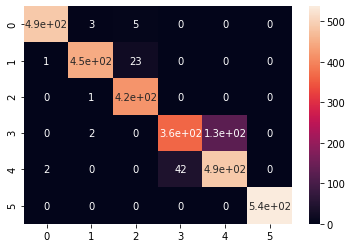

In [309]:
import seaborn as sns
sns.heatmap(confusion_matrix(np.argmax(y_test,axis=1),total_y),annot=True)

### Conclusion

In [360]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model","Accuracy","loss"]
x.add_row(["LSTM with one Layer",90.97,0.3087])
x.add_row(["LSTM with two Layer",91.78,0.3971])
x.add_row(["LSTM with three Layer",89.51,0.4863])
x.add_row(["Divide-Conquer Method",94.24,0.2042])
print(x)

+-----------------------+----------+--------+
|         Model         | Accuracy |  loss  |
+-----------------------+----------+--------+
|  LSTM with one Layer  |  90.97   | 0.3087 |
|  LSTM with two Layer  |  91.78   | 0.3971 |
| LSTM with three Layer |  89.51   | 0.4863 |
| Divide-Conquer Method |  94.24   | 0.2042 |
+-----------------------+----------+--------+


1. All three model is getting confused between standing and sitting, after running so many code at last I got 91.8% accuracy in LSTM with 2 layers.
2. Some code gives nan as my losses and get stuck in same accuracy of 16.83% for many epochs .